<a href="https://colab.research.google.com/github/isegura/seminarioUPM/blob/main/6_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Long Short Term Memory (LSTM)

In this notebook, we will learn how to use a BiLSTM to classify the sentiment of tweets about Covid-10. 


[Kaggle example](https://www.kaggle.com/anubhavsanyal/tensorflow-with-lstm-83-accuracy/notebook)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics



First, we should mount your google drive folder:

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")
root='drive/My Drive/Colab Notebooks/seminarioUPM/'


Mounted at /content/drive/


## Loading the data

In [ ]:
import pandas as pd

# reading the already cleaned data
train_data = pd.read_csv(root+'data/train.csv')
test_data = pd.read_csv(root+'data/test.csv')
# dropping indexes with nan

# training set
index_with_nan = train_data.index[train_data.isnull().any(axis=1)]
train_data.drop(index_with_nan,0, inplace=True)

# testing set
index_with_nan = test_data.index[test_data.isnull().any(axis=1)]
test_data.drop(index_with_nan,0, inplace=True)
print(f'Training instances: {train_data.shape[0]}, testing instances: {test_data.shape[0]}')
train_data.head()

Training instances: 41087, testing instances: 3795


,Corpus,label
0,advice talk neighbour family exchange phone nu...,4
1,coronavirus australia woolworth elderly disabl...,4
2,food stock panic food need stay calm stay safe,4
3,ready supermarket outbreak paranoid food stock...,0
4,news regionâs confirmed covid case came sulli...,4


Obtaining texts and labels:

In [ ]:
#texts
X_train = train_data.iloc[:,0]
X_test = test_data.iloc[:,0]

#labels
y_train = train_data.iloc[:,1]
y_test = test_data.iloc[:,1]

#before get_dummies()
#print('#before get_dummies()')
#for i in range(10):
#    print(i,y_train[i])
#print()

#converts from a categorial data to a one-hot encoding vector 
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
#after get_dummies()
#print('#after get_dummies()')
#y_train.head(10)

#convertir el dataframe en un array numpy
train_text=X_train.to_numpy()
train_labels = y_train.to_numpy() 


test_text = X_test.to_numpy()
test_labels = y_test.to_numpy() 

## From words to vectors

To transform texts to vectors we will use the keras tokenizer:

In [ ]:

#import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


MAX_WORDS = 40000
#the maximum number of words to keep, based on word frequency. 
#Only the most common num_words-1 words will be kept.

#oov_token: any unknown word will be replaced by the tag OOVthis will replace any unknown words with a token of our choosing

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='OOV')

# fitting the tokenizer on the texts
tokenizer.fit_on_texts(train_text)

word_index = tokenizer.word_index
print('size of the vocabulary:' , len(word_index))

#NUM_WORDS=min(len(word_index),MAX_WORDS)
NUM_WORDS=len(word_index)


size of the vocabulary: 30841


Now we represent the text (sequence) into vectors. We have to decide the maximum number of tokens in a sequence. Several studies have shown that this size could be 30.

<img src='https://www.researchgate.net/profile/Sifei-Han-2/publication/280206298/figure/fig1/AS:284595032477696@1444864151246/Distributions-of-tweets-with-different-numbers-of-tokens-from-a-dataset-of-10-000.png' scale=0.15>

Han, S., & Kavuluru, R. (2015, June). On assessing the sentiment of general tweets. In Canadian Conference on Artificial Intelligence (pp. 181-195). Springer, Cham.


We have to tranform tweets into sequences  (which will be vectors) for training and test texts.

* If a tweet has less than 30 tokens, we will add padding at the end of the sequence. 
* If a tweet has more than 30 tokens, we will remove tokens at the beginning of the sequence. 

In this way, all sequences have the same number of tokens (30).



In [ ]:
MAX_SEQUENCE_LENGTH=30 #lenght of the input sequences

# transform texts into vectors (id of vectors)
train_text_sequeces = tokenizer.texts_to_sequences(train_text)
#print("sequence:", str(len(train_text_sequeces[0]))+ ' tokens', train_text_sequeces[0])

# add padding (if the text has less than 30 tokens) or remove tokens from the beginning (if it has more than 30 tokens)
train_text_padded = pad_sequences(train_text_sequeces, maxlen=MAX_SEQUENCE_LENGTH, padding = 'post', truncating='pre') 
#print("after padding: ",train_text_padded[0])

#print(train_text_padded.shape) #41087 tweets (rows) x 30 words (maxlen)


#test to sequence#
test_text_sequeces = tokenizer.texts_to_sequences(test_text)
test_text_padded = pad_sequences(tokenizer.texts_to_sequences(test_text), maxlen=MAX_SEQUENCE_LENGTH, padding = 'post', truncating='pre') 


## Defining the model LSTM

First, we will define a very simple system with:
- a input layer: embedding with random initialization.
- a LSTM layer with 30 units. 
- a softmax with 5 output units (each unit represents a class sentiment: ext. negative, negative, neutral, positive, ext. positive.

To define, we will use some keras classes:

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

model = Sequential()

EMBEDDING_DIM = 100

# embedding layer
model.add(Embedding(NUM_WORDS+1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))

# LSTM layer
model.add(LSTM(MAX_SEQUENCE_LENGTH))

# second hidden layer
#model.add(Dense(10, activation='relu'))

# output dense layer, with 5 categories, as many as our sentiments
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           3084200   
_________________________________________________________________
lstm (LSTM)                  (None, 30)                15720     
_________________________________________________________________
dense (Dense)                (None, 5)                 155       
Total params: 3,100,075
Trainable params: 3,100,075
Non-trainable params: 0
_________________________________________________________________


We will use Adam Optimizer, which is an extension to stochastic gradient descent method. 

One of the most important parameter of a neural network is the learnig rate. 
* Its default learning rate for Adam is  0.001
* 0.01 typically works for standard multi-layer neural networks 
* The most common values are 0.1 and 0.01,
* There is not an algorithm to obtain it, the only method is trial and error.

<img src='https://miro.medium.com/max/1400/1*n79s9gvd0E8ALe9dLUEKAw.png' scale=0.50>

https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6

In [ ]:
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


#learning_rate=0.01
model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])

#https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
early_stop = EarlyStopping(monitor='val_loss', patience=3)

#If unspecified, batch_size will default to 32
#Advantages of using a batch size < number of all samples: requires less memory and trains faster
#Disadvantage the smaller the batch the less accurate the estimate of the gradient will be

#epochs: the number times that the learning algorithm will work through the entire training dataset.
#https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/

history = model.fit(train_text_padded, 
                       train_labels, 
                       epochs = 10, 
                       #validation_data=(validation_text_padded, validation_labels), 
                       validation_split=0.2,
                       callbacks=[early_stop])

print('trained...')

Epoch 1/10
1028/1028 [==============================] - 53s 32ms/step - loss: 1.2914 - accuracy: 0.4344 - val_loss: 0.8153 - val_accuracy: 0.6963
Epoch 2/10
1028/1028 [==============================] - 31s 30ms/step - loss: 0.7110 - accuracy: 0.7444 - val_loss: 0.7749 - val_accuracy: 0.7201
Epoch 3/10
1028/1028 [==============================] - 32s 31ms/step - loss: 0.5389 - accuracy: 0.8138 - val_loss: 0.7995 - val_accuracy: 0.7189
Epoch 4/10
1028/1028 [==============================] - 31s 30ms/step - loss: 0.4301 - accuracy: 0.8579 - val_loss: 0.8770 - val_accuracy: 0.7151
Epoch 5/10
1028/1028 [==============================] - 31s 31ms/step - loss: 0.3546 - accuracy: 0.8876 - val_loss: 0.9596 - val_accuracy: 0.6975
trained...


### How to interpret learning curves

https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

In [ ]:
#Function to plot learning curve
def plot_loss(loss, val_loss):
    fig, axs = plt.subplots(1)
    axs.plot(loss)
    axs.plot(val_loss)
    axs.set_title('Training and Validation Losses')
    axs.set_xlabel('Epoch')
    axs.set_ylabel('Loss')
    axs.legend(['Train', 'Val'])
    fig.tight_layout()
    plt.show()

    

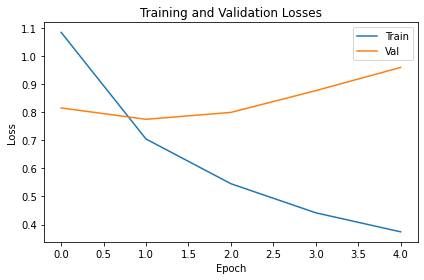

In [ ]:
plot_loss(history.history['loss'], history.history['val_loss'])

### Second model: BiLSTM 

Enhancing the performance by applying a BiLSTM layer. We also use dropout and another Dense layer

In [ ]:
from keras.layers import Bidirectional, Dropout

model2 = Sequential()

# embedding layer
model2.add(Embedding(NUM_WORDS+1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
# LSTM layer
model2.add(Bidirectional(LSTM(MAX_SEQUENCE_LENGTH)))
# second hidden layer
#model2.add(Dense(MAX_SEQUENCE_LENGTH, activation='relu'))
# dropout: reduce overfitting. During training, some number of layer outputs are randomly ignored or “dropped out.”
# A common value is a probability of 0.5 for retaining the output of each node in a hidden layer 
# and a value close to 1.0, such as 0.8, for retaining inputs from the visible layer.
#https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/
#model2.add(Dropout(0.4))
# third layer: can fix the vanishing gradients problem,
#https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/
#model2.add(Dense(10, activation = 'relu'))
# dropout 
#model2.add(Dropout(0.4))
# fourth layer 
#model2.add(Dense(10, activation = 'relu'))
# output dense layer, with 5 categories, as many as our sentiments
model2.add(Dense(5, activation='softmax'))

model2.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 100)           3084200   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 60)                31440     
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 305       
Total params: 3,115,945
Trainable params: 3,115,945
Non-trainable params: 0
_________________________________________________________________


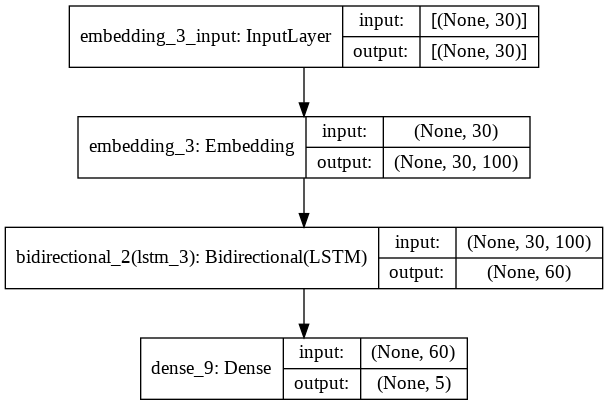

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# compiling the model and fitting it 
early_stop = EarlyStopping(monitor='val_loss', patience=3)

#learning_rate=0.01
model2.compile(loss=CategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])
history2 = model2.fit(train_text_padded, 
                       train_labels, 
                       epochs = 10, 
                        validation_split=0.2,
                       #validation_data=(validation_text_padded, validation_labels), 
                       callbacks=[early_stop])

Epoch 1/10
1028/1028 [==============================] - 36s 32ms/step - loss: 1.1290 - accuracy: 0.5272 - val_loss: 0.7361 - val_accuracy: 0.7357
Epoch 2/10
1028/1028 [==============================] - 32s 31ms/step - loss: 0.6086 - accuracy: 0.7820 - val_loss: 0.7456 - val_accuracy: 0.7403
Epoch 3/10
1028/1028 [==============================] - 32s 32ms/step - loss: 0.4460 - accuracy: 0.8440 - val_loss: 0.8102 - val_accuracy: 0.7207
Epoch 4/10
1028/1028 [==============================] - 32s 31ms/step - loss: 0.3542 - accuracy: 0.8828 - val_loss: 0.9135 - val_accuracy: 0.7176


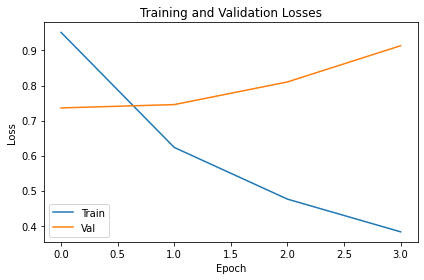

In [ ]:
plot_loss(history2.history['loss'], history2.history['val_loss'])

## Evaluation on the test dataset

In [ ]:
test_pred = model2.predict(test_text_padded)
test_pred = test_pred.round().astype(int)

In [ ]:
# transforming the pred vectors to its label:
test_pred_cat = np.zeros(test_pred.shape[0],)
test_labels_cat = np.zeros(test_pred.shape[0],)

for i in range(0,test_pred.shape[0],1):
  test_pred_cat[i] = test_pred[i].argmax()
  test_labels_cat[i] = test_labels[i].argmax()

test_pred_cat = test_pred_cat.astype(int)
test_labels_cat = test_labels_cat.astype(int)

In [ ]:
labels = {'Extremely Negative': 0,
          'Extremely Positive': 1,
          'Negative': 2,
          'Neutral': 3,
          'Positive': 4}
print(classification_report(test_labels_cat, test_pred_cat, target_names= labels.keys()))

                    precision    recall  f1-score   support

Extremely Negative       0.55      0.69      0.61       592
Extremely Positive       0.73      0.62      0.67       599
          Negative       0.63      0.56      0.59      1041
           Neutral       0.80      0.71      0.75       616
          Positive       0.58      0.65      0.61       947

          accuracy                           0.64      3795
         macro avg       0.66      0.65      0.65      3795
      weighted avg       0.65      0.64      0.64      3795



### Confuxion matrix

In [ ]:
conf_mat = confusion_matrix(test_labels_cat, test_pred_cat)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels.keys(), yticklabels=labels.keys(),cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()